In [12]:
from astropy.timeseries import LombScargle
from astropy import time
from astropy.coordinates import get_sun, EarthLocation, AltAz, solar_system_ephemeris
from astropy import units as un
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
(2 * un.AA).to(un.m)

<Quantity 2.e-10 m>

In [15]:
data = pd.read_csv('./data/sksolartimevariation5804d.txt', skiprows=13, sep='\s+', names=['t_mean(s)', 't_mean-t_start(s)', 't_end-t_mean(s)', 'nu_flux(1e6cm-2s-1)', 'flux_up_error(1e6cm-2s-1)', 'flux_down_error(1e6cm-2s-1)'])

In [16]:
data

,t_mean(s),t_mean-t_start(s),t_end-t_mean(s),nu_flux(1e6cm-2s-1),flux_up_error(1e6cm-2s-1),flux_down_error(1e6cm-2s-1)
0,833654760,170100,277380,2.74,0.63,0.53
1,834127080,175500,210060,2.83,0.75,0.62
2,834550800,213180,230160,2.30,0.53,0.45
3,834997020,199380,212640,1.79,0.55,0.44
4,835380420,170520,265680,3.15,0.74,0.61
...,...,...,...,...,...,...
1338,1525315550,172739,172774,2.36,0.36,0.33
1339,1525703838,215064,215054,2.26,0.31,0.29
1340,1526138206,216970,216028,1.88,0.33,0.29
1341,1526588224,232102,226109,1.90,0.38,0.28


In [17]:
times = data['t_mean(s)'].values * un.s
flux = data['nu_flux(1e6cm-2s-1)'].values * un.cm**-2 * un.s**-1 * 1e6
flux_err_up = data['flux_up_error(1e6cm-2s-1)'].values * un.cm**-2 * un.s**-1 * 1e6
flux_err_down = data['flux_down_error(1e6cm-2s-1)'].values * un.cm**-2 * un.s**-1 * 1e6

In [5]:
lsp = LombScargle(times, flux, dy=0.5*(flux_err_up+flux_err_down), normalization='log')

In [6]:
freq, power = lsp.autopower(minimum_frequency=1e-8/un.year, maximum_frequency=20/un.year)

In [7]:
freq

<Quantity [1.00000000e-08, 9.10281354e-03, 1.82056171e-02, ...,
           1.99806538e+01, 1.99897566e+01, 1.99988594e+01] 1 / yr>

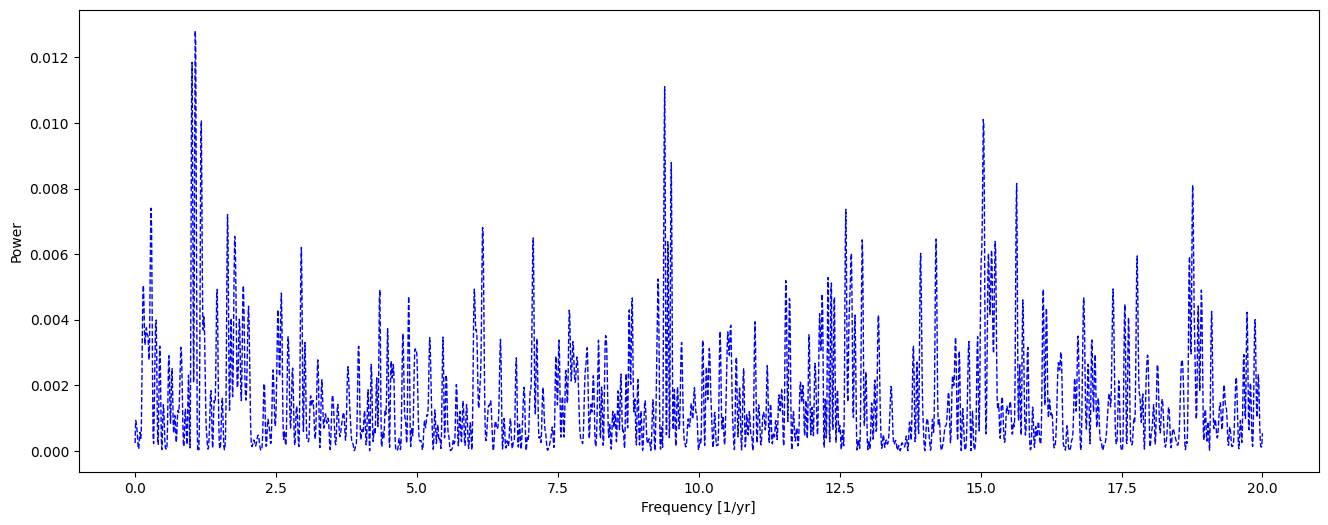

In [8]:
plt.figure(figsize=(16, 6))
plt.plot(freq, power, '--', lw=1, c='b')
plt.xlabel('Frequency [1/yr]')
plt.ylabel('Power')
plt.show()

$\nu$ = 9.43 1/yr is the frquency from 2016 paper

Checking the False Alarm Probability (FAP) for the 2016 paper

In [9]:
freq_943 = freq[np.argmin(np.abs(freq - 9.43/un.year))]
power_943 = power[np.argmin(np.abs(freq - 9.43/un.year))]

In [10]:
power_943

<Quantity 0.00051287>

In [11]:
lsp.false_alarm_probability(power_943, method='bootstrap')

1.0

In [12]:
lsp.false_alarm_probability(power_943, method='naive')

<Quantity 1.>

In [13]:
lsp.false_alarm_probability(power_943, method='baluev')

<Quantity 1.>

In [14]:
lsp.false_alarm_probability(power_943, method='davies')

<Quantity 1413.27645876>

The _davies_ method is giving **FAP $>$ 1**, so I am specifying the optional min and max frequency kwargs.



In [15]:
lsp.false_alarm_probability(power_943, method='bootstrap', minimum_frequency=freq.min(), maximum_frequency=freq.max())

1.0

In [16]:
lsp.false_alarm_probability(power_943, method='naive', minimum_frequency=freq.min(), maximum_frequency=freq.max())

<Quantity 1.>

In [17]:
lsp.false_alarm_probability(power_943, method='baluev', minimum_frequency=freq.min(), maximum_frequency=freq.max())

<Quantity 1.>

In [18]:
lsp.false_alarm_probability(power_943, method='davies', minimum_frequency=freq.min(), maximum_frequency=freq.max())

<Quantity 185.57354517>

_Davies_ method still erroneous


However, now use the frequency for which the _power is maximum_

$\nu$ = $\nu_{max\quad power}$

In [19]:
freq_max = freq[np.nanargmax(power)]
power_max = power[np.nanargmax(power)]

freq_max

<Quantity 1.06502802 1 / yr>

In [20]:
power.max()

<Quantity 0.01281338>

In [21]:
lsp.false_alarm_probability(power_max, method='bootstrap')

0.897

In [22]:
lsp.false_alarm_probability(power_max, method='naive')

<Quantity 0.46610671>

In [23]:
lsp.false_alarm_probability(power_max, method='baluev')

<Quantity 0.84534996>

In [24]:
lsp.false_alarm_probability(power_max, method='davies')

<Quantity 1.86659052>

_Davies_ method still giving invalid FAP

Specifying the min and max frequency kwargs to see if it works

In [25]:
lsp.false_alarm_probability(power_max, method='bootstrap', minimum_frequency=freq.min(), maximum_frequency=freq.max())

0.269

In [26]:
lsp.false_alarm_probability(power_max, method='naive', minimum_frequency=freq.min(), maximum_frequency=freq.max())

<Quantity 0.07884727>

In [27]:
lsp.false_alarm_probability(power_max, method='baluev', minimum_frequency=freq.min(), maximum_frequency=freq.max())

<Quantity 0.21686123>

In [28]:
lsp.false_alarm_probability(power_max, method='davies', minimum_frequency=freq.min(), maximum_frequency=freq.max())

<Quantity 0.24444535>

Using all powers from the LSP

In [29]:
fap_davies = lsp.false_alarm_probability(power, method='davies', minimum_frequency=freq.min(), maximum_frequency=freq.max())

In [30]:
print(fap_davies.min(), fap_davies.max())

0.24444534729856113 191.3322277383209


In [31]:
fap_baluev = lsp.false_alarm_probability(power, method='baluev', minimum_frequency=freq.min(), maximum_frequency=freq.max())
print(fap_baluev.min(), fap_baluev.max())

0.21686122583299355 1.0


In [32]:
fap_naive = lsp.false_alarm_probability(power, method='naive', minimum_frequency=freq.min(), maximum_frequency=freq.max())
print(fap_naive.min(), fap_naive.max())

0.07884727093714422 1.0


In [33]:
fap_bootstrap = lsp.false_alarm_probability(power, method='bootstrap', minimum_frequency=freq.min(), maximum_frequency=freq.max())
print(fap_bootstrap.min(), fap_bootstrap.max())

0.263 1.0


### Davies method has some issues??